# Check for significance in BMI subsystems

Try integrating mouse KO data (from MGI)

3/23/21: switch to sampled gene sets results

6/14/21: add enrichment for just seed genes

6/29/21: update to be more consistent with NetColoc notebooks

8/9/21: add Brittany's BMI genes

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

# need ddot to parse the ontology
import ddot
from ddot import Ontology

# annotate the clusters
# gprofiler prelim annotation
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from statsmodels.stats import contingency_tables

import requests

# find human orthologs of mouse genes
import mygene
mg = mygene.MyGeneInfo()

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

# % matplotlib inline

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


# Load interactome

In [2]:

interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

number of nodes:
18820

number of edges:
2693109


In [26]:
nodes = list(G_int.nodes)

# First load overlap network computed in significance_network_overlap_sampling_210519.ipynb

In [3]:

ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
657

number of edges:
5287


In [4]:
node_df = pd.DataFrame.from_dict(dict(G_overlap.nodes(data=True)), orient='index')
node_df.head()

,z_hBMI,hBMI_seeds,rBMI_seeds,z_both,z_rBMI
EMILIN2,3.2993274507173282,0,0,4.319544181058447,1.3092196047771212
BACE2,2.8994208805031514,1,0,5.1352520072145325,1.7711302425066986
ABCF3,1.3422866127228419,0,0,3.1658845767318398,2.358575692198711
EIF2AK4,6.620334089952722,0,1,61.32723979498262,9.263466006655953
HSP90AB1,2.4374615254638914,0,1,25.352273034423177,10.401096702274387


In [62]:
# compute cosine similarity transformation
from netcoloc import network_colocalization

In [64]:
network_colocalization.transform_edges?

In [70]:
G_overlap_cosSim = network_colocalization.transform_edges(G_overlap,edge_weight_threshold=0.98)
print(len(G_overlap_cosSim.nodes()))
print(len(G_overlap_cosSim.edges()))

computing the adjacency matrix...
computing the cosine similarity...
rank transforming...
number of transformed edges returned = 
3427
657
5287


In [71]:
print(len(G_overlap_cosSim.nodes()))
print(len(G_overlap_cosSim.edges()))

657
3427


In [73]:
#upload G_cosSim to ndex
print(len(G_overlap_cosSim.nodes()))
print(len(G_overlap_cosSim.edges()))
G_overlap_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_overlap_cosSim)
G_overlap_cosSim_cx.set_name('rat_human_BMI_CosSim98') 
for node_id, node in G_overlap_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_NetColoc_CosSim = G_overlap_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

657
3427
NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


# Build multiscale systems map



In [5]:
cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})

In [6]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_rat_human_BMI_z3_sampling_edges.txt
# nodes: 61
# edges: 61


In [7]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_hier.nodes()))
print('\nnumber of edges:')
print(len(G_hier.edges()))

number of nodes:
61

number of edges:
61


In [8]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
# relabel nodes in G_ASD
# G_ASD=nx.relabel_nodes(G_ASD,dict(hier_df['CD_CommunityName']))
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,SULT1A2 FCHO2 HPX TIMM10B ADD3 PPP1R14D CCL14 ...,642,False,9.326,,,0,0.0,0.0,120,C877,C877,0
1,SGCB LGI3 GPRC5B STXBP5 CORIN FAM177A1 STXBP6 ...,11,False,3.459,,,0,0.0,0.0,5,C898,C898,1
2,BCL11B PKIB LDB2 LYL1 NR2F1 GATA3 PKIA AKNA ZF...,10,False,3.322,,,0,0.0,0.0,6,C904,C904,2
3,SPINT1 WWC1 FEZ2 PKP3 PROM2 SSH3 TNIK CORIN CAPN1,9,False,3.17,,,0,0.0,0.0,10,C906,C906,3
4,LINGO1 ZNF629 ZKSCAN2 ZKSCAN5 ZNF202 ZNF768 ZN...,7,False,2.807,,,0,0.0,0.0,11,C911,C911,4


# add fraction rat/human seeds

In [9]:
hier_df.index=hier_df['name']
hier_df.head()

H_seeds_overlap = node_df[node_df['hBMI_seeds']=='1'].index.tolist()
print(len(H_seeds_overlap))

R_seeds_overlap = node_df[node_df['rBMI_seeds']=='1'].index.tolist()
print(len(R_seeds_overlap))

num_d1_seeds, num_d2_seeds = [],[]
frac_d1_seeds, frac_d2_seeds=[],[]
systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    num_H_temp = len(list(np.intersect1d(system_genes,H_seeds_overlap)))
    num_R_temp = len(list(np.intersect1d(system_genes,R_seeds_overlap)))
    if (num_H_temp+num_H_temp)>0: # keep the system if it has at least 1 seed genes
        systems_keep.append(c)
        num_d1_seeds.append(num_H_temp)
        num_d2_seeds.append(num_R_temp)
        
        frac_d1_seeds.append(num_H_temp/np.float(len(system_genes)))
        frac_d2_seeds.append(num_R_temp/np.float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.add(frac_d1_seeds,frac_d2_seeds))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print(len(hier_df))

hier_df.head()
    

228
114
61


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,,,
C877,SULT1A2 FCHO2 HPX TIMM10B ADD3 PPP1R14D CCL14 ...,642,False,9.326,,,0,0.0,0.0,120,C877,C877,0,227,114,0.353583,0.177570,0.468847
C898,SGCB LGI3 GPRC5B STXBP5 CORIN FAM177A1 STXBP6 ...,11,False,3.459,,,0,0.0,0.0,5,C898,C898,1,4,2,0.363636,0.181818,0.454545
C904,BCL11B PKIB LDB2 LYL1 NR2F1 GATA3 PKIA AKNA ZF...,10,False,3.322,,,0,0.0,0.0,6,C904,C904,2,3,2,0.300000,0.200000,0.500000
C906,SPINT1 WWC1 FEZ2 PKP3 PROM2 SSH3 TNIK CORIN CAPN1,9,False,3.17,,,0,0.0,0.0,10,C906,C906,3,3,1,0.333333,0.111111,0.555556
C911,LINGO1 ZNF629 ZKSCAN2 ZKSCAN5 ZNF202 ZNF768 ZN...,7,False,2.807,,,0,0.0,0.0,11,C911,C911,4,4,1,0.571429,0.142857,0.285714


In [10]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print(len(G_hier.nodes()))
print(len(G_hier.edges()))

61
61


# System validation with mammalian phenotype ontology + mouse KO data

In [11]:
# download MGI phenotype data
url = 'http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt'
r = requests.get(url,allow_redirects=True)
open('MGI_PhenoGenoMP.rpt','wb').write(r.content)

# parse the downloaded MGI phenotype data
mgi_df = pd.read_csv('MGI_PhenoGenoMP.rpt',sep='\t',
                    names=['MGI_Allele_Accession_ID','Allele symbol','involves','MP','PMID','MGI_marker_accession_ID'])
# extract gene names
gene_name = [a.split('<')[0] for a in mgi_df['Allele symbol'].tolist()]
mgi_df['gene_name']=gene_name
mgi_df.index=mgi_df['gene_name']
display(mgi_df.head())

# map mouse genes to human orthologs
mouse_genes = list(np.unique(mgi_df['gene_name']))
# mouse_genes = [g for g in mouse_genes if (not g.startswith('+'))]
mg_mapped = mg.querymany(mouse_genes,as_dataframe=True,species=['mouse','human'],scopes='symbol',fields='symbol')

# drop genes with no human ortholog
print(len(mg_mapped))
mg_mapped = mg_mapped.dropna(subset=['symbol'])
print(len(mg_mapped))
# drop duplicates
mg_mapped = mg_mapped[~mg_mapped.index.duplicated(keep='first')]
print(len(mg_mapped))
mg_mapped.head()

mgi_df['human_ortholog']=mgi_df['gene_name'].map(dict(mg_mapped['symbol']))
mgi_df.head()

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name
gene_name,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24130...done.
Finished.
35 input query terms found dup hits:
	[('Adam1a', 2), ('Adam1b', 2), ('Ccdc39', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 2), ('Fer1l4',
12238 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [12]:
# download the mammalian phenotype ontology, parse with ddot
url = 'http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology'
r = requests.get(url,allow_redirects=True)
open('MPheno_OBO.ontology','wb').write(r.content)
ddot.parse_obo('MPheno_OBO.ontology',
               'parsed_mp.txt',
              'id2name_mp.txt',
              'id2namespace_mp.txt',
              'altID_mp.txt')


MP2desc = pd.read_csv('id2name_mp.txt',sep='\t',
                      names=['MP','description'],index_col='MP')

MP2desc=MP2desc.loc[MP2desc.index.dropna()] # drop NAN from index
print(len(MP2desc))


display(MP2desc.head())

hierarchy = pd.read_table('parsed_mp.txt',
                          sep='\t',
                          header=None,
                          names=['Parent', 'Child', 'Relation', 'Namespace'])

display(hierarchy.head())

MPO = Ontology.from_table(
    table=hierarchy,
    parent='Parent',
    child='Child',
    add_root_name='MP:00SUPER',
    ignore_orphan_terms=True)
#MPO.clear_node_attr()
#MPO.clear_edge_attr()

# add description to node attribute
terms_keep = list(np.unique(hierarchy['Parent'].tolist()+hierarchy['Child'].tolist()))
MPO.node_attr=MP2desc.loc[terms_keep]

MPO

14470


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13337 terms, 0 gene-term relations, 16846 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

In [13]:
MP_focal_list = ['MP:0002089','MP:0002069','MP:0003633','MP:0001186']

In [14]:
# test for enrichment in root node
OR_p_list,OR_CI_list,log_OR_list = [],[],[]
num_genes_in_term_list=[]

MP_keep_list = []

# root node is the largest node
hier_df.index=hier_df['name']
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]

# get list of node names from G_int
G_int_nodes = list(G_int.nodes())

# add a negative control phenotype: abnormal mature B cell morphology: MP:0008171
# negative controls are tough here because we're dealing with development... which impacts almost everything
for MP_focal in MP_focal_list:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal,verbose=False)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=[MP_focal]


    # check enrichment in root node
    focal_genes = hier_df['CD_MemberList'].loc[root_node].split(' ')
    mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
    mgi_temp = mgi_temp.dropna(subset=['human_ortholog'])
    mgi_genes = list(np.unique(mgi_temp['human_ortholog']))
    mgi_genes = list(np.intersect1d(mgi_genes,G_int_nodes)) 
    
    if (len(mgi_genes)>10) and (len(mgi_genes)<20000): # only test if there are at least 10 genes, and fewer than 2000 genes
        print('\n'+MP_desc_focal)
        print('number of genes in root node = '+str(len(focal_genes)))
        print('number of genes in focal MPO term = '+str(len(mgi_genes)))

        q00 = len(np.intersect1d(mgi_genes,focal_genes))
        print('number overlapping genes = '+str(q00))
        q01 = len(mgi_genes)-q00
        q10 = len(focal_genes)-q00
        q11 = len(G_int_nodes)-q00-q01-q10
        table_temp = [[q00,q01],[q10,q11]]

        CT= contingency_tables.Table2x2(table_temp)
        OR_p_temp = CT.log_oddsratio_pvalue()
        OR_CI_temp = CT.log_oddsratio_confint()
        log_OR_temp = CT.log_oddsratio
        print(OR_p_temp)
        print(OR_CI_temp)
        print(log_OR_temp)

        OR_p_list.append(OR_p_temp)
        OR_CI_list.append(OR_CI_temp)
        log_OR_list.append(log_OR_temp)
        num_genes_in_term_list.append(len(mgi_genes))
        
        MP_keep_list.append(MP_focal)

    
OR_CI_lower, OR_CI_upper = zip(*OR_CI_list)

root_KO_df = pd.DataFrame({'OR_p':OR_p_list,'log_OR':log_OR_list,
                           'log_OR_CI_lower':OR_CI_lower,'log_OR_CI_upper':OR_CI_upper,
                          'num_genes_in_term':num_genes_in_term_list},
                          index=MP_keep_list)


abnormal postnatal growth/weight/body size
number of genes in root node = 642
number of genes in focal MPO term = 3417
number overlapping genes = 155
6.819855476926834e-05
(0.19057471563766598, 0.5599351882711512)
0.3752549519544086

abnormal consumption behavior
number of genes in root node = 642
number of genes in focal MPO term = 644
number overlapping genes = 34
0.008456839959789408
(0.12185212440403032, 0.8312699351797588)
0.4765610297918945

abnormal nervous system physiology
number of genes in root node = 642
number of genes in focal MPO term = 2154
number overlapping genes = 121
3.4760149767645307e-09
(0.40904154488759426, 0.8152352019272128)
0.6121383734074035

pigmentation phenotype
number of genes in root node = 642
number of genes in focal MPO term = 521
number overlapping genes = 23
0.20214710837691463
(-0.14864711332768232, 0.7026035181507528)
0.27697820241153526


# Test enrichment for all systems

In [15]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall

MP_full_results_df=pd.DataFrame(index=hier_df.index.tolist())

for MP_focal in MP_focal_top:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]
    print(MP_desc_focal)

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=MP_focal


    hyper_p_list = []
    num_genes_list = []
    genes_id_list = []

    OR_p_list,OR_CI_list,log_OR_list=[],[],[]
    for focal_cluster in hier_df.index.tolist():
        #print(focal_cluster)
        mFocal_genes = hier_df['CD_MemberList'].loc[focal_cluster].split(' ')


        from scipy.stats import hypergeom
        M=len(list(G_int.nodes())) # only keep genes in PCnet
        # Look up all entries matching focal_terms, and mFocal_genes
        mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
        mgi_temp = mgi_temp.dropna(subset=['human_ortholog'])
        mgi_genes = list(np.unique(mgi_temp['human_ortholog']))
        new_index=[g.upper() for g in mgi_temp.index.tolist()] 
        mgi_temp.index=new_index

        N=len(np.intersect1d(list(np.unique(mgi_temp.index.tolist())),list(G_int.nodes()))) # only keep genes in PCnet

        if len(np.intersect1d(mFocal_genes,mgi_temp.index.tolist()))>0:
            mgi_genes = mgi_temp.index.tolist()
            mgi_genes = list(np.intersect1d(mgi_genes,list(G_int.nodes())))
            x = len(np.intersect1d(mFocal_genes,mgi_genes))
            #print(x)
            n=len(mFocal_genes)

            #mgi_temp['MP_description']=mgi_temp['MP'].map(dict(MP2desc['description']))



            #print(hypergeom.sf(x,M,n,N))
            hyper_p_list.append(hypergeom.sf(x,M,n,N))
            num_genes_list.append(x)
            genes_id_list.append(' '.join(list(np.intersect1d(mFocal_genes,mgi_genes))))

            q00 = len(np.intersect1d(mgi_genes,mFocal_genes))
            q01 = len(mgi_genes)-q00

            q10 = len(mFocal_genes)-q00
            q11 = len(list(G_int.nodes()))-q00-q01-q10

            table_temp = [[q00,q01],[q10,q11]]

            CT= contingency_tables.Table2x2(table_temp)
            OR_p_temp = CT.log_oddsratio_pvalue()
            OR_CI_temp = CT.log_oddsratio_confint()
            log_OR_temp = CT.log_oddsratio
            #print(OR_p_temp)


            OR_p_list.append(OR_p_temp)
            OR_CI_list.append(OR_CI_temp)
            log_OR_list.append(log_OR_temp)


        else:
            hyper_p_list.append(1)
            num_genes_list.append(0)
            genes_id_list.append('')

            OR_p_list.append(1)
            OR_CI_list.append(0)
            log_OR_list.append(0)



    MP_focal_df = pd.DataFrame({MP_desc_focal+':-log(OR_p)':-np.log10(OR_p_list),
                                MP_desc_focal+':log_OR':log_OR_list,
                                MP_desc_focal+':num_genes':num_genes_list,
                                MP_desc_focal+':gene_ids':genes_id_list},index=hier_df.index.tolist())

    if MP_desc_focal+':-log(OR_p)' not in MP_full_results_df.columns.tolist():
        MP_full_results_df=MP_full_results_df.join(MP_focal_df)


abnormal postnatal growth/weight/body size
Genes and Terms to keep: 39
abnormal consumption behavior
Genes and Terms to keep: 51
abnormal nervous system physiology
Genes and Terms to keep: 365
pigmentation phenotype
Genes and Terms to keep: 125


# gprofiler annotation of clusters

In [17]:

# print out GO pathways

# hier_df = hier_df.sort_values('name')

# ....this needs to be much more elegant...

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['GO:BP'],no_evidences=False))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-3] # set a stringent pvalue threshold
            
            # try sorting by precision + recall
            #gp_temp['prec_plus_recall']=gp_temp['precision']+gp_temp['recall']
            gp_temp = gp_temp.sort_values('p_value',ascending=True)
            
            gp_temp.index=gp_temp['name']
            for t in gp_temp.index.tolist():
                if t.lower().find('dopamin')>-1:
                    print(gp_temp.loc[t][['p_value','intersections']])
                    
            gp_cols_keep = ['description','name','p_value','precision','recall',
                            'query_size','effective_domain_size','intersection_size','native','source',
                           'term_size','intersections']

            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
                gp_temp[gp_cols_keep].to_csv('../tables/rat_human_BMI_hierarchy_GO/'+str(p)+'.csv',sep=',',
                          index=False)
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C877
642


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
glycosaminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,25,"[NCAN, CHST9, CHST14, NDST2, HS3ST1, CHST7, GP...",glycosaminoglycan biosynthetic process,GO:0006024,1.851520e-11,"[GO:0006023, GO:0030203]",0.043328,query_1,577,0.233645,True,GO:BP,107,"[[TAS], [TAS], [IDA, TAS], [TAS, IEA], [TAS], ..."
aminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,25,"[NCAN, CHST9, CHST14, NDST2, HS3ST1, CHST7, GP...",aminoglycan biosynthetic process,GO:0006023,4.488268e-11,"[GO:0006022, GO:0009059, GO:1901137, GO:1901566]",0.043328,query_1,577,0.219298,True,GO:BP,114,"[[TAS], [TAS], [IDA, TAS], [TAS, IEA], [TAS], ..."
proteoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,17,"[NCAN, CHST9, CHST14, NDST2, CHST7, CSPG4, CHS...",proteoglycan biosynthetic process,GO:0030166,1.832713e-08,"[GO:0006029, GO:0009101]",0.029463,query_1,577,0.265625,True,GO:BP,64,"[[TAS], [ISS, IBA, TAS], [IDA, TAS], [IBA, IEA..."
proteoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,19,"[NCAN, CHST9, CHST14, NDST2, CHST7, HS3ST4, GP...",proteoglycan metabolic process,GO:0006029,5.342865e-08,[GO:0009100],0.032929,query_1,577,0.211111,True,GO:BP,90,"[[TAS], [ISS, IBA, TAS], [IDA, IBA, TAS], [IBA..."
glycosaminoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,25,"[NCAN, CHST9, CHST14, NDST2, HS3ST1, CHST7, GP...",glycosaminoglycan metabolic process,GO:0030203,5.342865e-08,[GO:0006022],0.043328,query_1,577,0.157233,True,GO:BP,159,"[[TAS], [TAS, NAS], [IDA, TAS], [TAS, IEA], [T..."


C898
11


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C904
10


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
negative regulation of transcription by RNA polymerase II,"""Any process that stops, prevents, or reduces ...",18123,6,"[LDB2, NR2F1, GATA3, PKIA, ZFPM2, LMO1]",negative regulation of transcription by RNA po...,GO:0000122,0.00011,"[GO:0006357, GO:0006366, GO:0045892]",0.6,query_1,10,0.006674,True,GO:BP,899,"[[IBA], [IDA, IBA], [IBA, IEA], [IEA], [IDA, I..."


C906
9


""


C911
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C913
7


""


C914
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C915
7


""


C924
6


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C925
6


""


C926
5


""


C930
5


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C931
5


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
regulation of small GTPase mediated signal transduction,"""Any process that modulates the frequency, rat...",18123,4,"[ABR, PLEKHG5, ARHGAP11B, ARHGEF26]",regulation of small GTPase mediated signal tra...,GO:0051056,0.000142,"[GO:0007264, GO:1902531]",0.8,query_1,5,0.012158,True,GO:BP,329,"[[TAS], [TAS], [TAS], [TAS]]"
small GTPase mediated signal transduction,"""Any series of molecular signals in which a sm...",18123,4,"[ABR, PLEKHG5, ARHGAP11B, ARHGEF26]",small GTPase mediated signal transduction,GO:0007264,0.000442,[GO:0035556],0.8,query_1,5,0.007692,True,GO:BP,520,"[[TAS], [IBA, TAS], [TAS], [TAS]]"


C933
5


""


C935
4


""


C937
4


""


C878
214
p_value                                                3.92898e-07
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: regulation of dopamine secretion, dtype: object
p_value                                                3.92898e-07
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: dopamine secretion, dtype: object
p_value                                                3.95263e-06
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: dopamine transport, dtype: object


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
glycosaminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,25,"[HS3ST6, HS3ST3A1, HS3ST3B1, NCAN, CHST9, CHST...",glycosaminoglycan biosynthetic process,GO:0006024,5.742858e-23,"[GO:0006023, GO:0030203]",0.125,query_1,200,0.233645,True,GO:BP,107,"[[TAS], [TAS], [TAS], [TAS], [TAS], [IDA, TAS]..."
aminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,25,"[HS3ST6, HS3ST3A1, HS3ST3B1, NCAN, CHST9, CHST...",aminoglycan biosynthetic process,GO:0006023,1.605855e-22,"[GO:0006022, GO:0009059, GO:1901137, GO:1901566]",0.125,query_1,200,0.219298,True,GO:BP,114,"[[TAS], [TAS], [TAS], [TAS], [TAS], [IDA, TAS]..."
glycosaminoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,25,"[HS3ST6, HS3ST3A1, HS3ST3B1, NCAN, CHST9, CHST...",glycosaminoglycan metabolic process,GO:0030203,6.735357e-19,[GO:0006022],0.125,query_1,200,0.157233,True,GO:BP,159,"[[TAS], [TAS], [TAS], [TAS], [TAS, NAS], [IDA,..."
aminoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,25,"[HS3ST6, HS3ST3A1, HS3ST3B1, NCAN, CHST9, CHST...",aminoglycan metabolic process,GO:0006022,4.327245e-18,"[GO:0043170, GO:1901135, GO:1901564]",0.125,query_1,200,0.144509,True,GO:BP,173,"[[TAS], [TAS], [TAS], [TAS], [TAS, NAS], [IDA,..."
proteoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,17,"[HS3ST3B1, GAL3ST4, NCAN, CHST9, CHST14, NDST1...",proteoglycan biosynthetic process,GO:0030166,1.165841e-16,"[GO:0006029, GO:0009101]",0.085,query_1,200,0.265625,True,GO:BP,64,"[[TAS], [NAS], [TAS], [ISS, IBA, TAS], [IDA, T..."


C880
157


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C882
53


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
protein demethylation,"""The removal of a methyl group, from a protein...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",protein demethylation,GO:0006482,8.601366e-12,"[GO:0008214, GO:0070988]",0.166667,query_1,48,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
protein dealkylation,"""The removal of an alkyl group from a protein ...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",protein dealkylation,GO:0008214,8.601366e-12,[GO:0006464],0.166667,query_1,48,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
histone demethylation,"""The modification of histones by removal of me...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",histone demethylation,GO:0016577,8.601366e-12,"[GO:0006482, GO:0016570]",0.166667,query_1,48,0.250000,True,GO:BP,32,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
histone lysine demethylation,"""The modification of a histone by the removal ...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",histone lysine demethylation,GO:0070076,8.601366e-12,[GO:0016577],0.166667,query_1,48,0.266667,True,GO:BP,30,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
demethylation,"""The process of removing one or more methyl gr...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",demethylation,GO:0070988,5.279820e-09,[GO:0008152],0.166667,query_1,48,0.108108,True,GO:BP,74,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."


C885
31


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
mesenchyme development,"""The process whose specific outcome is the pro...",18123,7,"[BNC2, GATA3, AKNA, DCHS1, PBLD, ZFPM2, SOX8]",mesenchyme development,GO:0060485,0.000072,"[GO:0009888, GO:0048513]",0.250000,query_1,28,0.023649,True,GO:BP,296,"[[IEA], [IMP], [ISS, IEA], [IMP], [IMP], [IEA]..."
cell fate commitment,"""The commitment of cells to specific cell fate...",18123,6,"[SPDEF, GATA3, SOX6, BCL11B, SOX8, SOX5]",cell fate commitment,GO:0045165,0.000354,"[GO:0030154, GO:0048869]",0.214286,query_1,28,0.022472,True,GO:BP,267,"[[IEA], [ISS, IBA, IEA], [IBA], [IEA], [ISS, I..."
negative regulation of cell differentiation,"""Any process that stops, prevents, or reduces ...",18123,8,"[SPDEF, GATA3, SOX6, THY1, PBLD, ZFPM2, SOX8, ...",negative regulation of cell differentiation,GO:0045596,0.000660,"[GO:0030154, GO:0045595, GO:0048523, GO:0051093]",0.285714,query_1,28,0.011412,True,GO:BP,701,"[[IEA], [IMP], [IMP], [ISS, IBA, IEA], [IMP], ..."


C887
17


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
detection of chemical stimulus involved in sensory perception of smell,"""The series of events involved in the percepti...",18123,9,"[OR6B2, OR5A2, OR2A4, OR4X1, GPR148, OR8S1, OR...",detection of chemical stimulus involved in sen...,GO:0050911,1.862953e-10,"[GO:0007608, GO:0050907]",0.6,query_1,15,0.022613,True,GO:BP,398,"[[IEA], [IEA], [IBA, IEA], [IEA], [IBA], [IEA]..."
sensory perception of smell,"""The series of events required for an organism...",18123,9,"[OR6B2, OR5A2, OR2A4, OR4X1, GPR148, OR8S1, OR...",sensory perception of smell,GO:0007608,2.236816e-10,[GO:0007606],0.6,query_1,15,0.021176,True,GO:BP,425,"[[IEA], [IEA], [IBA, IEA], [IEA], [IBA], [IEA]..."
detection of chemical stimulus involved in sensory perception,"""The series of events in which a chemical stim...",18123,9,"[OR6B2, OR5A2, OR2A4, OR4X1, GPR148, OR8S1, OR...",detection of chemical stimulus involved in sen...,GO:0050907,2.635640e-10,"[GO:0007606, GO:0009593, GO:0050906]",0.6,query_1,15,0.020134,True,GO:BP,447,"[[IEA], [IEA], [IBA, IEA], [IEA], [IBA], [IEA]..."
detection of chemical stimulus,"""The series of events in which a chemical stim...",18123,9,"[OR6B2, OR5A2, OR2A4, OR4X1, GPR148, OR8S1, OR...",detection of chemical stimulus,GO:0009593,4.291680e-10,"[GO:0042221, GO:0051606]",0.6,query_1,15,0.018595,True,GO:BP,484,"[[IEA], [IEA], [IBA, IEA], [IEA], [IBA], [IEA]..."
sensory perception of chemical stimulus,"""The series of events required for an organism...",18123,9,"[OR6B2, OR5A2, OR2A4, OR4X1, GPR148, OR8S1, OR...",sensory perception of chemical stimulus,GO:0007606,4.530831e-10,[GO:0007600],0.6,query_1,15,0.018109,True,GO:BP,497,"[[IEA], [IEA], [IBA, IEA], [IEA], [IBA], [IEA]..."


C888
17


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
membrane fusion,"""The membrane organization process that joins ...",18123,10,"[STX16-NPEPL1, VPS8, VPS4A, VPS11, STX7, TSNAR...",membrane fusion,GO:0061025,1.437103e-14,[GO:0061024],0.6250,query_1,16,0.055866,True,GO:BP,179,"[[IEA], [IMP, IBA], [IMP], [IMP, IBA], [IBA], ..."
vacuolar transport,"""The directed movement of substances into, out...",18123,9,"[MON1B, VPS33A, RBSN, VPS4A, VPS11, MON1A, TGF...",vacuolar transport,GO:0007034,2.047561e-13,"[GO:0006810, GO:0009987]",0.5625,query_1,16,0.058442,True,GO:BP,154,"[[IEA], [IMP], [IMP], [IMP], [IMP], [IEA], [IM..."
vesicle fusion,"""Fusion of the membrane of a transport vesicle...",18123,8,"[VPS8, VPS4A, VPS11, STX7, TSNARE1, TGFBRAP1, ...",vesicle fusion,GO:0006906,1.182612e-12,"[GO:0016050, GO:0016192, GO:0090174]",0.5000,query_1,16,0.072727,True,GO:BP,110,"[[IMP, IBA], [IMP], [IMP, IBA], [IBA], [IBA], ..."
intracellular protein transport,"""The directed movement of proteins in a cell, ...",18123,13,"[STX16-NPEPL1, MON1B, VPS33A, VPS4A, VPS11, ST...",intracellular protein transport,GO:0006886,1.182612e-12,"[GO:0015031, GO:0034613, GO:0046907]",0.8125,query_1,16,0.013065,True,GO:BP,995,"[[IEA], [IEA], [IBA], [IMP], [HMP, IEA], [IBA,..."
organelle membrane fusion,"""The joining of two lipid bilayers to form a s...",18123,8,"[VPS8, VPS4A, VPS11, STX7, TSNARE1, TGFBRAP1, ...",organelle membrane fusion,GO:0090174,1.351605e-12,"[GO:0048284, GO:0061025]",0.5000,query_1,16,0.070175,True,GO:BP,114,"[[IMP, IBA], [IMP], [IMP, IBA], [IBA], [IBA], ..."


C889
16


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
activation of MAPK activity,"""The initiation of the activity of the inactiv...",18123,5,"[MAP2K5, MAPK1, MAP2K6, MAP2K3, MAP2K1]",activation of MAPK activity,GO:0000187,0.000013,"[GO:0032147, GO:0043406]",0.357143,query_1,14,0.032258,True,GO:BP,155,"[[ISS, IBA, IEA], [TAS, IEA], [IDA, IBA, TAS, ..."
positive regulation of MAP kinase activity,"""Any process that activates or increases the f...",18123,5,"[MAP2K5, MAPK1, MAP2K6, MAP2K3, MAP2K1]",positive regulation of MAP kinase activity,GO:0043406,0.000071,"[GO:0043405, GO:0043410, GO:0071902]",0.357143,query_1,14,0.021368,True,GO:BP,234,"[[ISS, IBA, IEA], [TAS, IEA], [IDA, IBA, TAS, ..."
positive regulation of MAPK cascade,"""Any process that activates or increases the f...",18123,6,"[MAP2K5, MAPK1, MAP2K6, MAP2K3, DNAJC27, MAP2K1]",positive regulation of MAPK cascade,GO:0043410,0.000160,"[GO:0000165, GO:0043408, GO:1902533]",0.428571,query_1,14,0.011070,True,GO:BP,542,"[[ISS, IBA, IEA], [TAS, IEA], [IDA, IBA, TAS, ..."
regulation of MAP kinase activity,"""Any process that modulates the frequency, rat...",18123,5,"[MAP2K5, MAPK1, MAP2K6, MAP2K3, MAP2K1]",regulation of MAP kinase activity,GO:0043405,0.000220,[GO:0071900],0.357143,query_1,14,0.015823,True,GO:BP,316,"[[ISS, IBA, IEA], [TAS, IEA], [IDA, IBA, TAS, ..."
positive regulation of protein serine/threonine kinase activity,"""Any process that increases the rate, frequenc...",18123,5,"[MAP2K5, MAPK1, MAP2K6, MAP2K3, MAP2K1]",positive regulation of protein serine/threonin...,GO:0071902,0.000220,"[GO:0045860, GO:0071900]",0.357143,query_1,14,0.015773,True,GO:BP,317,"[[ISS, IBA, IEA], [TAS, IEA], [IDA, IBA, TAS, ..."


C890
15


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C892
14


""


C895
11


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C883
34


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
glycosaminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,24,"[HS3ST6, GPC6, HS3ST1, HS3ST3A1, CHST1, HS3ST3...",glycosaminoglycan biosynthetic process,GO:0006024,1.181556e-45,"[GO:0006023, GO:0030203]",0.75000,query_1,32,0.224299,True,GO:BP,107,"[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
aminoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,24,"[HS3ST6, GPC6, HS3ST1, HS3ST3A1, CHST1, HS3ST3...",aminoglycan biosynthetic process,GO:0006023,3.243878e-45,"[GO:0006022, GO:0009059, GO:1901137, GO:1901566]",0.75000,query_1,32,0.210526,True,GO:BP,114,"[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [TA..."
glycosaminoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,24,"[HS3ST6, GPC6, HS3ST1, HS3ST3A1, CHST1, HS3ST3...",glycosaminoglycan metabolic process,GO:0030203,1.357160e-41,[GO:0006022],0.75000,query_1,32,0.150943,True,GO:BP,159,"[[TAS], [TAS], [TAS], [TAS], [IDA, IBA, TAS], ..."
aminoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,24,"[HS3ST6, GPC6, HS3ST1, HS3ST3A1, CHST1, HS3ST3...",aminoglycan metabolic process,GO:0006022,8.956439e-41,"[GO:0043170, GO:1901135, GO:1901564]",0.75000,query_1,32,0.138728,True,GO:BP,173,"[[TAS], [TAS], [TAS], [TAS], [IDA, IBA, TAS], ..."
carbohydrate derivative biosynthetic process,"""The chemical reactions and pathways resulting...",18123,29,"[HS3ST6, GPC6, HS3ST1, HS3ST3A1, CHST1, HS3ST3...",carbohydrate derivative biosynthetic process,GO:1901137,1.408469e-36,"[GO:1901135, GO:1901576]",0.90625,query_1,32,0.042274,True,GO:BP,686,"[[TAS], [TAS], [TAS], [TAS], [TAS], [TAS], [IB..."


C879
169
p_value                                                8.73168e-08
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: regulation of dopamine secretion, dtype: object
p_value                                                8.73168e-08
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: dopamine secretion, dtype: object
p_value                                                9.46478e-07
intersections    [SYT17, SYT4, SYT2, SYT12, SYT1, SYT6, SYT9, S...
Name: dopamine transport, dtype: object


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
cellular response to calcium ion,"""Any process that results in a change in state...",18123,14,"[CPNE6, SYT17, SYT4, RASA4, SYT2, SYT12, SYT1,...",cellular response to calcium ion,GO:0071277,2.882145e-11,"[GO:0051592, GO:0071248]",0.088608,query_1,158,0.162791,True,GO:BP,86,"[[IBA, IEA], [IBA], [IBA], [IMP, IEA], [IBA], ..."
calcium-ion regulated exocytosis,"""The release of intracellular molecules (e.g. ...",18123,13,"[SYT17, GNAI2, SYT4, DOC2A, SYT2, SYT12, UNC13...",calcium-ion regulated exocytosis,GO:0017156,2.882145e-11,[GO:0045055],0.082278,query_1,158,0.196970,True,GO:BP,66,"[[IBA], [IEA], [IBA, NAS, IEA], [IMP, IEA], [I..."
anterograde trans-synaptic signaling,"""Cell-cell signaling from pre to post-synapse,...",18123,30,"[CPNE6, GRIA3, GNAI2, SYT4, DOC2A, SYT2, RIMS4...",anterograde trans-synaptic signaling,GO:0098916,3.979633e-10,[GO:0099537],0.189873,query_1,158,0.042076,True,GO:BP,713,"[[TAS], [TAS], [IEA], [IEA], [TAS, IEA], [IBA,..."
chemical synaptic transmission,"""The vesicular release of classical neurotrans...",18123,30,"[CPNE6, GRIA3, GNAI2, SYT4, DOC2A, SYT2, RIMS4...",chemical synaptic transmission,GO:0007268,3.979633e-10,[GO:0098916],0.189873,query_1,158,0.042076,True,GO:BP,713,"[[TAS], [TAS], [IEA], [IEA], [TAS, IEA], [IBA,..."
trans-synaptic signaling,"""Cell-cell signaling in either direction acros...",18123,30,"[CPNE6, GRIA3, GNAI2, SYT4, DOC2A, SYT2, RIMS4...",trans-synaptic signaling,GO:0099537,4.233497e-10,[GO:0099536],0.189873,query_1,158,0.041609,True,GO:BP,721,"[[TAS], [TAS], [IEA], [IEA], [TAS, IEA], [IBA,..."


C932
5


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C901
10


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C902
10


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C907
9


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
muscle system process,"""A organ system process carried out at the lev...",18123,6,"[MYH2, DMD, CASQ2, MYH4, AKAP6, MYOZ2]",muscle system process,GO:0003012,0.000015,[GO:0003008],0.666667,query_1,9,0.012739,True,GO:BP,471,"[[IDA, TAS, NAS], [IMP, ISS, TAS, IEA], [IMP, ..."
release of sequestered calcium ion into cytosol by sarcoplasmic reticulum,"""The process in which the release of sequester...",18123,3,"[DMD, CASQ2, AKAP6]",release of sequestered calcium ion into cytoso...,GO:0014808,0.000045,"[GO:0070296, GO:1903514]",0.333333,query_1,9,0.083333,True,GO:BP,36,"[[ISS, IEA], [IMP, ISS, IBA], [IC]]"
actin-myosin filament sliding,"""The sliding movement of actin thin filaments ...",18123,3,"[MYH2, DMD, MYH4]",actin-myosin filament sliding,GO:0033275,0.000045,[GO:0070252],0.333333,query_1,9,0.076923,True,GO:BP,39,"[[NAS], [TAS], [NAS]]"
striated muscle tissue development,"""The process whose specific outcome is the pro...",18123,5,"[MYF5, DMD, VGLL2, AKAP6, MYOZ2]",striated muscle tissue development,GO:0014706,0.000045,[GO:0060537],0.555556,query_1,9,0.012821,True,GO:BP,390,"[[IBA, TAS, IEA], [IEA], [IEA], [ISS], [ISS, I..."
release of sequestered calcium ion into cytosol by endoplasmic reticulum,"""The directed movement of calcium ion from end...",18123,3,"[DMD, CASQ2, AKAP6]",release of sequestered calcium ion into cytoso...,GO:1903514,0.000045,[GO:0051209],0.333333,query_1,9,0.081081,True,GO:BP,37,"[[ISS, IEA], [IMP, ISS, IBA], [IC]]"


C909
8


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
negative regulation of phosphatase activity,"""Any process that decreases the rate or freque...",18123,3,"[WNK1, LMTK3, LMTK2]",negative regulation of phosphatase activity,GO:0010923,0.000557,"[GO:0010921, GO:0035305, GO:0051346]",0.428571,query_1,7,0.027523,True,GO:BP,109,"[[IDA], [IDA], [IEA]]"
negative regulation of dephosphorylation,"""Any process the stops, prevents, or reduces t...",18123,3,"[WNK1, LMTK3, LMTK2]",negative regulation of dephosphorylation,GO:0035305,0.000557,"[GO:0016311, GO:0035303, GO:0045936]",0.428571,query_1,7,0.025424,True,GO:BP,118,"[[IDA], [IDA], [IEA]]"


C884
32
p_value                                                3.84878e-14
intersections    [SYT12, SYT1, SYT6, SYT17, SYT7, SYT4, SYT9, S...
Name: regulation of dopamine secretion, dtype: object
p_value                                                3.84878e-14
intersections    [SYT12, SYT1, SYT6, SYT17, SYT7, SYT4, SYT9, S...
Name: dopamine secretion, dtype: object
p_value                                                4.62405e-13
intersections    [SYT12, SYT1, SYT6, SYT17, SYT7, SYT4, SYT9, S...
Name: dopamine transport, dtype: object


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
regulation of exocytosis,"""Any process that modulates the frequency, rat...",18123,13,"[UNC13D, SYTL4, SYT12, SYT1, SYT6, SYT17, SYT7...",regulation of exocytosis,GO:0017157,1.349706e-15,"[GO:0006887, GO:0060627, GO:1903530]",0.433333,query_1,30,0.062500,True,GO:BP,208,"[[IMP, IGI], [IMP], [IBA], [ISS, IBA, TAS, IEA..."
calcium-ion regulated exocytosis,"""The release of intracellular molecules (e.g. ...",18123,10,"[SYT12, SYT1, SYT6, SYT17, UNC13B, SYT7, DOC2A...",calcium-ion regulated exocytosis,GO:0017156,1.349706e-15,[GO:0045055],0.333333,query_1,30,0.151515,True,GO:BP,66,"[[IBA], [ISS, IBA, IEA], [IMP, IBA, IEA], [IBA..."
exocytosis,"""A process of secretion by a cell that results...",18123,19,"[SYTL2, UNC13D, SYTL4, SYT12, SYT1, SYTL3, SYT...",exocytosis,GO:0006887,1.349706e-15,"[GO:0016192, GO:0032940]",0.633333,query_1,30,0.020971,True,GO:BP,906,"[[IDA, IBA, IEA], [IMP, IGI, TAS, IEA], [IMP, ..."
regulation of calcium ion-dependent exocytosis,"""Any process that modulates the frequency, rat...",18123,9,"[SYT12, SYT1, SYT6, SYT17, SYT7, DOC2A, SYT4, ...",regulation of calcium ion-dependent exocytosis,GO:0017158,1.483487e-15,"[GO:0017156, GO:1903305]",0.300000,query_1,30,0.219512,True,GO:BP,41,"[[IBA], [ISS, IBA, IEA], [IBA], [IBA], [IBA, I..."
cellular response to calcium ion,"""Any process that results in a change in state...",18123,10,"[SYT12, RASAL1, SYT1, SYT6, SYT17, SYT7, SYT4,...",cellular response to calcium ion,GO:0071277,1.332028e-14,"[GO:0051592, GO:0071248]",0.333333,query_1,30,0.116279,True,GO:BP,86,"[[IBA], [IEA], [ISS, IBA, IEA], [IBA], [IBA], ..."


C893
14


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C894
11


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
regulation of inflammatory response to antigenic stimulus,"""Any process that modulates the frequency, rat...",18123,4,"[VIPR1, MC4R, POMC, ADORA2B]",regulation of inflammatory response to antigen...,GO:0002861,0.000942,"[GO:0002437, GO:0050727, GO:0050776]",0.4,query_1,10,0.018182,True,GO:BP,220,"[[TAS], [TAS], [TAS], [TAS]]"
negative regulation of inflammatory response to antigenic stimulus,"""Any process that stops, prevents, or reduces ...",18123,4,"[VIPR1, MC4R, POMC, ADORA2B]",negative regulation of inflammatory response t...,GO:0002862,0.000942,"[GO:0002437, GO:0002861, GO:0050728, GO:0050777]",0.4,query_1,10,0.019417,True,GO:BP,206,"[[TAS], [TAS], [TAS], [TAS]]"
adenylate cyclase-modulating G protein-coupled receptor signaling pathway,"""The series of molecular signals generated as ...",18123,4,"[VIPR1, MC4R, GNAO1, GNAI2]",adenylate cyclase-modulating G protein-coupled...,GO:0007188,0.000942,[GO:0007186],0.4,query_1,10,0.016949,True,GO:BP,236,"[[IBA], [IDA, IBA, TAS], [IBA, IEA], [IBA, TAS..."
inflammatory response to antigenic stimulus,"""An inflammatory response to an antigenic stim...",18123,4,"[VIPR1, MC4R, POMC, ADORA2B]",inflammatory response to antigenic stimulus,GO:0002437,0.000962,"[GO:0006954, GO:0006955]",0.4,query_1,10,0.015936,True,GO:BP,251,"[[TAS], [TAS], [TAS], [TAS]]"


C896
11


""


C929
5


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
microtubule cytoskeleton organization,"""A process that is carried out at the cellular...",18123,4,"[TUBA4A, NDE1, TUBA4B, TBCD]",microtubule cytoskeleton organization,GO:0000226,0.000511,"[GO:0007010, GO:0007017]",0.8,query_1,5,0.006033,True,GO:BP,663,"[[IBA], [IMP, ISS, IBA, TAS, IEA], [IBA], [IDA..."


C899
11


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C934
4


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
transcription initiation from RNA polymerase II promoter,"""Any process involved in the assembly of the R...",18123,3,"[TAF4, TAF10, TAF11]",transcription initiation from RNA polymerase I...,GO:0006367,0.000545,"[GO:0006352, GO:0006366]",0.75,query_1,4,0.013216,True,GO:BP,227,"[[IDA, IBA, TAS], [IDA, TAS, IC], [IBA, TAS, I..."
regulation of signal transduction by p53 class mediator,"""Any process that modulates the frequency, rat...",18123,3,"[TAF4, TAF10, TAF11]",regulation of signal transduction by p53 class...,GO:1901796,0.000545,"[GO:0072331, GO:1902531]",0.75,query_1,4,0.014851,True,GO:BP,202,"[[TAS], [TAS], [TAS]]"
"DNA-templated transcription, initiation","""Any process involved in the assembly of the R...",18123,3,"[TAF4, TAF10, TAF11]","DNA-templated transcription, initiation",GO:0006352,0.000567,"[GO:0006351, GO:0032774]",0.75,query_1,4,0.010381,True,GO:BP,289,"[[IDA, IBA, TAS, IEA], [IDA, TAS, IC, IEA], [I..."
signal transduction by p53 class mediator,"""An intracellular signaling process that is in...",18123,3,"[TAF4, TAF10, TAF11]",signal transduction by p53 class mediator,GO:0072331,0.000567,[GO:0035556],0.75,query_1,4,0.010345,True,GO:BP,290,"[[TAS], [TAS], [TAS]]"


C903
10


""


C881
68


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
viral gene expression,"""A process by which a viral gene is converted ...",18123,9,"[RPL4, EIF3A, CSDE1, SPCS1, PSMC3, RPL28, EIF2...",viral gene expression,GO:0019080,0.000051,[GO:0016032],0.155172,query_1,58,0.037975,True,GO:BP,237,"[[TAS], [IDA], [IDA], [IMP], [IDA], [TAS], [IS..."
mRNA metabolic process,"""The chemical reactions and pathways involving...",18123,14,"[SF3A3, RPL4, SNU13, HNRNPA3, CSDE1, SNRPC, PS...",mRNA metabolic process,GO:0016071,0.000147,[GO:0016070],0.241379,query_1,58,0.015909,True,GO:BP,880,"[[IDA, IMP, IBA, TAS, IC, IEA], [TAS], [IDA, I..."
ribonucleoprotein complex biogenesis,"""A cellular process that results in the biosyn...",18123,10,"[SF3A3, RPL4, SNU13, HSP90AB1, EIF3A, SNRPC, X...",ribonucleoprotein complex biogenesis,GO:0022613,0.000362,[GO:0044085],0.172414,query_1,58,0.021142,True,GO:BP,473,"[[IDA, TAS], [TAS], [IBA, TAS, IEA], [IDA], [I..."
peptide metabolic process,"""The chemical reactions and pathways involving...",18123,14,"[RPL4, EIF3A, CSDE1, SPCS1, RPL28, NPEPPS, EIF...",peptide metabolic process,GO:0006518,0.000362,"[GO:0043603, GO:1901564]",0.241379,query_1,58,0.014028,True,GO:BP,998,"[[TAS, NAS, IC, IEA], [IDA, IBA, TAS, IC, IEA]..."
establishment of protein localization to organelle,"""The directed movement of a protein to a speci...",18123,10,"[KPNA3, RPL4, HSP90AB1, KPNB1, SPCS1, RPL28, N...",establishment of protein localization to organ...,GO:0072594,0.000746,"[GO:0033365, GO:0045184]",0.172414,query_1,58,0.019120,True,GO:BP,523,"[[IBA, TAS, IEA], [TAS], [IEA], [IDA, IMP, IBA..."


C916
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C919
6


""


C921
6


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C920
6


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
establishment of protein localization to endoplasmic reticulum,"""The directed movement of a protein to a speci...",18123,3,"[RPL28, SPCS1, RPL4]",establishment of protein localization to endop...,GO:0072599,0.000058,"[GO:0070972, GO:0072594]",0.75,query_1,4,0.026087,True,GO:BP,115,"[[TAS], [IBA], [TAS]]"
protein targeting to ER,"""The process of directing proteins towards the...",18123,3,"[RPL28, SPCS1, RPL4]",protein targeting to ER,GO:0045047,0.000058,"[GO:0006605, GO:0072599]",0.75,query_1,4,0.027027,True,GO:BP,111,"[[TAS], [IBA], [TAS]]"
protein localization to endoplasmic reticulum,"""A process in which a protein is transported t...",18123,3,"[RPL28, SPCS1, RPL4]",protein localization to endoplasmic reticulum,GO:0070972,0.000076,[GO:0033365],0.75,query_1,4,0.020833,True,GO:BP,144,"[[TAS], [IBA], [TAS]]"
viral gene expression,"""A process by which a viral gene is converted ...",18123,3,"[RPL28, SPCS1, RPL4]",viral gene expression,GO:0019080,0.000214,[GO:0016032],0.75,query_1,4,0.012658,True,GO:BP,237,"[[TAS], [IMP], [TAS]]"
peptide metabolic process,"""The chemical reactions and pathways involving...",18123,4,"[RPL28, SPCS1, RPL4, RPL39L]",peptide metabolic process,GO:0006518,0.000214,"[GO:0043603, GO:1901564]",1.00,query_1,4,0.004008,True,GO:BP,998,"[[TAS, NAS, IC, IEA], [IBA, IEA], [TAS, NAS, I..."


C905
9


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
mitochondrial translation,"""The chemical reactions and pathways resulting...",18123,4,"[MTIF3, TRUB2, MRPL14, MRPL2]",mitochondrial translation,GO:0032543,0.000039,"[GO:0006412, GO:0140053]",0.5,query_1,8,0.029630,True,GO:BP,135,"[[IDA, IBA], [IMP], [TAS], [IBA, TAS]]"
mitochondrial gene expression,"""The process in which a mitochondrial gene's s...",18123,4,"[MTIF3, TRUB2, MRPL14, MRPL2]",mitochondrial gene expression,GO:0140053,0.000045,[GO:0010467],0.5,query_1,8,0.024096,True,GO:BP,166,"[[IDA, IBA], [IMP], [TAS], [IBA, TAS]]"


C922
6


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
transcription by RNA polymerase III,"""The synthesis of RNA from a DNA template by R...",18123,3,"[GTF3C2, POLR3F, SNAPC3]",transcription by RNA polymerase III,GO:0006383,0.000079,[GO:0006351],0.5,query_1,6,0.06383,True,GO:BP,47,"[[IDA, IBA, IC], [NAS, IEA], [IBA, TAS]]"


C910
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C923
6


""


C886
27


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
protein demethylation,"""The removal of a methyl group, from a protein...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",protein demethylation,GO:0006482,1.366969e-14,"[GO:0008214, GO:0070988]",0.32,query_1,25,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
protein dealkylation,"""The removal of an alkyl group from a protein ...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",protein dealkylation,GO:0008214,1.366969e-14,[GO:0006464],0.32,query_1,25,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
histone demethylation,"""The modification of histones by removal of me...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",histone demethylation,GO:0016577,1.366969e-14,"[GO:0006482, GO:0016570]",0.32,query_1,25,0.250000,True,GO:BP,32,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
histone lysine demethylation,"""The modification of a histone by the removal ...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",histone lysine demethylation,GO:0070076,1.366969e-14,[GO:0016577],0.32,query_1,25,0.266667,True,GO:BP,30,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."
demethylation,"""The process of removing one or more methyl gr...",18123,8,"[KDM3B, KDM8, KDM6B, KDM5D, KDM5A, KDM6A, PHF2...",demethylation,GO:0070988,8.779226e-12,[GO:0008152],0.32,query_1,25,0.108108,True,GO:BP,74,"[[IBA], [IDA, IBA], [IMP, IBA, IEA], [IDA, IEA..."


C912
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
proteoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,6,"[CSPG5, NCAN, CSPG4, CHST9, CHST13, CHST14]",proteoglycan biosynthetic process,GO:0030166,3.781603e-13,"[GO:0006029, GO:0009101]",1.000000,query_1,6,0.093750,True,GO:BP,64,"[[TAS], [TAS], [TAS], [ISS, IBA, TAS], [IDA, I..."
proteoglycan metabolic process,"""The chemical reactions and pathways involving...",18123,6,"[CSPG5, NCAN, CSPG4, CHST9, CHST13, CHST14]",proteoglycan metabolic process,GO:0006029,1.570191e-12,[GO:0009100],1.000000,query_1,6,0.066667,True,GO:BP,90,"[[TAS], [TAS], [TAS], [ISS, IBA, TAS], [IDA, I..."
chondroitin sulfate biosynthetic process,"""The chemical reactions and pathways resulting...",18123,5,"[CSPG5, NCAN, CSPG4, CHST9, CHST13]",chondroitin sulfate biosynthetic process,GO:0030206,1.616934e-12,"[GO:0006024, GO:0030204, GO:0044272, GO:0050650]",0.833333,query_1,6,0.200000,True,GO:BP,25,"[[TAS], [TAS], [TAS], [TAS], [IDA, TAS]]"
chondroitin sulfate proteoglycan biosynthetic process,"""The chemical reactions and pathways resulting...",18123,5,"[CSPG5, NCAN, CSPG4, CHST9, CHST13]",chondroitin sulfate proteoglycan biosynthetic ...,GO:0050650,2.138025e-12,"[GO:0030166, GO:0050654]",0.833333,query_1,6,0.166667,True,GO:BP,30,"[[TAS], [TAS], [TAS], [TAS], [IDA, TAS]]"
mucopolysaccharide metabolic process,"""The chemical reactions and pathways involving...",18123,6,"[CSPG5, NCAN, CSPG4, CHST9, CHST13, CHST14]",mucopolysaccharide metabolic process,GO:1903510,2.138025e-12,[GO:0030203],1.000000,query_1,6,0.051724,True,GO:BP,116,"[[TAS], [TAS], [TAS], [TAS], [IDA, TAS], [IDA,..."


C897
11


""


C891
15
p_value                                                1.64819e-17
intersections    [SYT6, SYT17, SYT9, SYT12, SYT1, SYT4, SYT7, S...
Name: dopamine secretion, dtype: object
p_value                                                1.64819e-17
intersections    [SYT6, SYT17, SYT9, SYT12, SYT1, SYT4, SYT7, S...
Name: regulation of dopamine secretion, dtype: object
p_value                                                2.64743e-16
intersections    [SYT6, SYT17, SYT9, SYT12, SYT1, SYT4, SYT7, S...
Name: dopamine transport, dtype: object


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
calcium-ion regulated exocytosis,"""The release of intracellular molecules (e.g. ...",18123,10,"[SYT6, SYT17, DOC2A, SYT9, SYT12, UNC13B, SYT1...",calcium-ion regulated exocytosis,GO:0017156,1.047462e-19,[GO:0045055],0.714286,query_1,14,0.151515,True,GO:BP,66,"[[IMP, IBA, IEA], [IBA], [IMP, IEA], [IBA, IEA..."
regulation of calcium ion-dependent exocytosis,"""Any process that modulates the frequency, rat...",18123,9,"[SYT6, SYT17, DOC2A, SYT9, SYT12, SYT1, SYT4, ...",regulation of calcium ion-dependent exocytosis,GO:0017158,3.161101e-19,"[GO:0017156, GO:1903305]",0.642857,query_1,14,0.219512,True,GO:BP,41,"[[IBA], [IBA], [IMP, IEA], [IBA, IEA], [IBA], ..."
regulation of regulated secretory pathway,"""Any process that modulates the frequency, rat...",18123,11,"[RIMS4, SYT6, SYT17, UNC13D, DOC2A, SYT9, SYT1...",regulation of regulated secretory pathway,GO:1903305,3.663541e-19,"[GO:0017157, GO:0045055]",0.785714,query_1,14,0.075862,True,GO:BP,145,"[[ISS], [IBA], [IBA], [IMP, IGI], [IMP, IEA], ..."
signal release from synapse,"""Any signal release from a synapse."" [GOC:dos]",18123,11,"[RIMS4, RPH3A, SYT6, DOC2A, SYT9, SYT12, UNC13...",signal release from synapse,GO:0099643,4.357507e-19,"[GO:0023061, GO:0099536]",0.785714,query_1,14,0.071429,True,GO:BP,154,"[[ISS], [IEA], [IEA], [IEA], [IEA], [IEA], [IS..."
neurotransmitter secretion,"""The regulated release of neurotransmitter fro...",18123,11,"[RIMS4, RPH3A, SYT6, DOC2A, SYT9, SYT12, UNC13...",neurotransmitter secretion,GO:0007269,4.357507e-19,"[GO:0001505, GO:0006836, GO:0007268, GO:005164...",0.785714,query_1,14,0.071429,True,GO:BP,154,"[[ISS], [IEA], [IEA], [IEA], [IEA], [IEA], [IS..."


C908
8


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,


C900
10


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
histone lysine demethylation,"""The modification of a histone by the removal ...",18123,8,"[KDM3B, KDM8, KDM5D, KDM5A, KDM6A, PHF2, KDM3A...",histone lysine demethylation,GO:0070076,3.351181e-19,[GO:0016577],0.8,query_1,10,0.266667,True,GO:BP,30,"[[IBA], [IDA, IBA], [IDA, IEA], [IDA, IEA], [I..."
histone demethylation,"""The modification of histones by removal of me...",18123,8,"[KDM3B, KDM8, KDM5D, KDM5A, KDM6A, PHF2, KDM3A...",histone demethylation,GO:0016577,3.351181e-19,"[GO:0006482, GO:0016570]",0.8,query_1,10,0.250000,True,GO:BP,32,"[[IBA], [IDA, IBA], [IDA, IEA], [IDA, IEA], [I..."
protein dealkylation,"""The removal of an alkyl group from a protein ...",18123,8,"[KDM3B, KDM8, KDM5D, KDM5A, KDM6A, PHF2, KDM3A...",protein dealkylation,GO:0008214,3.351181e-19,[GO:0006464],0.8,query_1,10,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IDA, IEA], [IDA, IEA], [I..."
protein demethylation,"""The removal of a methyl group, from a protein...",18123,8,"[KDM3B, KDM8, KDM5D, KDM5A, KDM6A, PHF2, KDM3A...",protein demethylation,GO:0006482,3.351181e-19,"[GO:0008214, GO:0070988]",0.8,query_1,10,0.235294,True,GO:BP,34,"[[IBA], [IDA, IBA], [IDA, IEA], [IDA, IEA], [I..."
demethylation,"""The process of removing one or more methyl gr...",18123,8,"[KDM3B, KDM8, KDM5D, KDM5A, KDM6A, PHF2, KDM3A...",demethylation,GO:0070988,2.216715e-16,[GO:0008152],0.8,query_1,10,0.108108,True,GO:BP,74,"[[IBA], [IDA, IBA], [IDA, IEA], [IDA, IEA], [I..."


C928
5


""


C917
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
activation of MAPK activity,"""The initiation of the activity of the inactiv...",18123,4,"[MAP2K5, MAP2K6, MAP2K3, MAP2K1]",activation of MAPK activity,GO:0000187,0.000047,"[GO:0032147, GO:0043406]",0.571429,query_1,7,0.025806,True,GO:BP,155,"[[ISS, IBA, IEA], [IDA, IBA, TAS, IEA], [IBA, ..."
positive regulation of MAP kinase activity,"""Any process that activates or increases the f...",18123,4,"[MAP2K5, MAP2K6, MAP2K3, MAP2K1]",positive regulation of MAP kinase activity,GO:0043406,0.000166,"[GO:0043405, GO:0043410, GO:0071902]",0.571429,query_1,7,0.017094,True,GO:BP,234,"[[ISS, IBA, IEA], [IDA, IBA, TAS, IEA], [IBA, ..."
activation of protein kinase activity,"""Any process that initiates the activity of an...",18123,4,"[MAP2K5, MAP2K6, MAP2K3, MAP2K1]",activation of protein kinase activity,GO:0032147,0.000275,[GO:0045860],0.571429,query_1,7,0.011976,True,GO:BP,334,"[[ISS, IBA, IEA], [IDA, IBA, TAS, IEA], [IBA, ..."
positive regulation of protein serine/threonine kinase activity,"""Any process that increases the rate, frequenc...",18123,4,"[MAP2K5, MAP2K6, MAP2K3, MAP2K1]",positive regulation of protein serine/threonin...,GO:0071902,0.000275,"[GO:0045860, GO:0071900]",0.571429,query_1,7,0.012618,True,GO:BP,317,"[[ISS, IBA, IEA], [IDA, IBA, TAS, IEA], [IBA, ..."
regulation of MAP kinase activity,"""Any process that modulates the frequency, rat...",18123,4,"[MAP2K5, MAP2K6, MAP2K3, MAP2K1]",regulation of MAP kinase activity,GO:0043405,0.000275,[GO:0071900],0.571429,query_1,7,0.012658,True,GO:BP,316,"[[ISS, IBA, IEA], [IDA, IBA, TAS, IEA], [IBA, ..."


C918
7


,description,effective_domain_size,intersection_size,intersections,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size,evidences
name,,,,,,,,,,,,,,,,
chromosome segregation,"""The process in which genetic material, in the...",18123,4,"[OIP5, CENPF, KIF22, KNSTRN]",chromosome segregation,GO:0007059,0.00093,[GO:0009987],0.666667,query_1,6,0.011331,True,GO:BP,353,"[[IBA], [IDA, IMP, IBA, NAS], [IMP], [IMP, IBA..."


C927
5


""


C936
4


""


# Load annotated hierarchy to ndex

In [50]:
d1='rat'
d2='human'
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
MP_full_results_df['gprofiler_name'].loc[root_node]=d1+'-'+d2+'BMI systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

/Users/brinrosenthal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,abnormal postnatal growth/weight/body size:-log(OR_p),abnormal postnatal growth/weight/body size:log_OR,abnormal postnatal growth/weight/body size:num_genes,abnormal postnatal growth/weight/body size:gene_ids,abnormal consumption behavior:-log(OR_p),abnormal consumption behavior:log_OR,abnormal consumption behavior:num_genes,abnormal consumption behavior:gene_ids,abnormal nervous system physiology:-log(OR_p),abnormal nervous system physiology:log_OR,...,pigmentation phenotype:-log(OR_p),pigmentation phenotype:log_OR,pigmentation phenotype:num_genes,pigmentation phenotype:gene_ids,gprofiler_name,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_no_seeds
C877,4.260651,0.380119,155,A1CF ABL1 AGPAT1 AKAP6 AKNA AXIN1 BACE2 BBS2 B...,2.084666,0.478259,34,BBS2 BCL11B BDNF CASK CLN3 EIF2AK4 FUS GBA GLI...,8.641254,0.619358,...,0.532772,0.232979,22,BACE2 BCL2 CLCN2 CORIN CRB2 DPH1 GATA3 GBA HPS...,rat-humanBMI systems map,227,114,0.353583,0.177570,0.468847
C898,0.888914,0.951561,4,CORIN LSAMP SGCB SPOCK1,-0.000000,0.000000,0,,0.946152,1.072971,...,0.639335,1.261604,1,CORIN,C898,4,2,0.363636,0.181818,0.454545
C904,0.473118,0.663584,3,AKNA BCL11B GATA3,1.873784,1.958148,2,BCL11B NR2F1,0.050098,-0.144420,...,0.709799,1.367019,1,GATA3,C904,3,2,0.300000,0.200000,0.500000
C906,1.260275,1.288163,4,CORIN PKP3 PROM2 TNIK,0.630940,1.263442,1,SPINT1,0.497291,0.800629,...,0.790748,1.484857,1,CORIN,C906,3,1,0.333333,0.111111,0.555556
C911,-0.000000,0.000000,0,,-0.000000,0.000000,0,,0.092083,0.261225,...,-0.000000,0.000000,0,,C911,4,1,0.571429,0.142857,0.285714


In [51]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

In [52]:
G_hier_cx.set_name('rat_human_BMI_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    #print(data)
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        #print(value)
        #print(type(value))
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)
        
# some CDAPs properties were corrupted on networkx conversion. Fix them here
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# apply a template style (36041bac-d2e3-11eb-b666-0ac135e8bacf)
G_hier_cx.apply_template('ndexbio.org','36041bac-d2e3-11eb-b666-0ac135e8bacf')

In [53]:
#Upload to NDEx

SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


# Make the enrichment figure (redundant with above... integrate later)

In [18]:
# set some parameters
ratThresh='relaxed' # relaxed or stringent

num_reps=1000

# set type of gene mapper
mapper = 'PASCAL' # can be PASCAL or PREDIXCAN

adj_type = 'bonf' # can be bonf or BH
# bonf_p = .05/len(BMI_GIANT_pascal) #0.25/len(BMI_GIANT_pascal)
# print(bonf_p)

excl_rat_seeds = False # if true, exclude rat seed genes from relevant phenotype

In [19]:
# read in rat BMI seed genes, corresponding to parameters above
rat_bmi_genes=pd.read_csv('seed_genes/ratBMI_seed_'+ratThresh+'.txt',sep='\t')['0'].tolist()
print(len(rat_bmi_genes))

295


In [28]:
# read in human BMI seed genes, corresponding to parameters above
# h_bmi_genes=pd.read_csv('seed_genes/humanBMI_seed_'+mapper+'_'+adj_type+'_exclRatSeeds'+str(excl_rat_seeds)+ratThresh+'.txt',
#                                      sep='\t')['0'].tolist()
BMI_GIANT_pascal = pd.read_csv('/Users/brinrosenthal/Documents/CCBB_tickets_data/GIANT_genomics/BMI/GIANT_BMI_pascal.sum.genescores.txt',
                              sep='\t')
BMI_GIANT_pascal.index=BMI_GIANT_pascal['gene_symbol']
BMI_GIANT_pascal = BMI_GIANT_pascal.loc[list(np.intersect1d(BMI_GIANT_pascal.index.tolist(),list(G_int.nodes)))]
bonf_p = .05/len(BMI_GIANT_pascal)

h_bmi_genes = BMI_GIANT_pascal[BMI_GIANT_pascal['pvalue']<bonf_p].index.tolist()

print(len(h_bmi_genes))



1958


In [29]:
BMI_GIANT_pascal.loc[h_bmi_genes].head()

,chromosome,start,end,strand,gene_id,gene_symbol,numSnps,pvalue,Status
gene_symbol,,,,,,,,,
A3GALT2,chr1,33772366,33786699,-,127550,A3GALT2,171,1.284589e-07,DAVIES_SUCCESS
AADAT,chr4,170981372,171011372,-,51166,AADAT,269,7.579147e-07,DAVIES_SUCCESS
AARS,chr16,70286296,70323412,-,16,AARS,31,1.125766e-13,DAVIES_LOWPRECISION_FAREBROTHER_SUCCESS
AATK,chr17,79091095,79139872,-,9625,AATK,386,1.000000e-12,DAVIES_LOWPRECISION_FAREBROTHER_FAIL
ABCB6,chr2,220074487,220085174,-,10058,ABCB6,112,4.647868e-07,DAVIES_SUCCESS


In [30]:
from statsmodels.stats import contingency_tables
from scipy.stats import hypergeom

In [31]:
# MP:0001186 pigmentation phenotype
# MP:0001533 skeletal phenotype
MP_focal_list = ['MP:0002089','MP:0002069','MP:0003633','MP:0001186']
OR_p_list,OR_CI_list,log_OR_list = [],[],[]
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
for MP_focal in MP_focal_list:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]
    print(MP_desc_focal)

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=MP_focal


    # check enrichment in root node
    focal_genes = hier_df['CD_MemberList'].loc[root_node].split(' ')
    print(len(focal_genes))

    mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
    mgi_genes = list(np.unique(mgi_temp['gene_name']))
    mgi_genes = [g.upper() for g in mgi_genes]
    print(len(mgi_genes))
    mgi_genes = list(np.intersect1d(mgi_genes,G_int.nodes()))
    print(len(mgi_genes))

    q00 = len(np.intersect1d(mgi_genes,focal_genes))
    q01 = len(mgi_genes)-q00

    q10 = len(focal_genes)-q00
    q11 = len(G_int.nodes())-q00-q01-q10

    table_temp = [[q00,q01],[q10,q11]]
    print(table_temp)

    CT= contingency_tables.Table2x2(table_temp)
    OR_p_temp = CT.log_oddsratio_pvalue()
    OR_CI_temp = CT.log_oddsratio_confint()
    log_OR_temp = CT.log_oddsratio
    print(OR_p_temp)
    print(OR_CI_temp)
    print(log_OR_temp)
    
    OR_p_list.append(OR_p_temp)
    OR_CI_list.append(OR_CI_temp)
    log_OR_list.append(log_OR_temp)
    
    print(hypergeom.sf(q00,len(G_int.nodes()),len(focal_genes),len(mgi_genes)))
    
OR_CI_lower, OR_CI_upper = zip(*OR_CI_list)

abnormal postnatal growth/weight/body size
Genes and Terms to keep: 39
642
5331
3428
[[156, 3272], [486, 14906]]
5.3085491618541094e-05
(0.19572542329444978, 0.5642941388416406)
0.38000978106804517
3.5181907506282694e-05
abnormal consumption behavior
Genes and Terms to keep: 51
642
921
644
[[34, 610], [608, 17568]]
0.008456839959789408
(0.12185212440403032, 0.8312699351797588)
0.4765610297918945
0.004689601410896944
abnormal nervous system physiology
Genes and Terms to keep: 365
642
3096
2157
[[122, 2035], [520, 16143]]
1.8239970065474677e-09
(0.418697261566041, 0.8236686053111935)
0.6211829334386172
5.006440775126809e-09
pigmentation phenotype
Genes and Terms to keep: 125
642
992
521
[[23, 498], [619, 17680]]
0.20214710837691463
(-0.14864711332768232, 0.7026035181507528)
0.27697820241153526
0.08477612597089522


In [32]:
np.exp(np.subtract(log_OR_list,OR_CI_lower))
print(np.exp(OR_CI_lower))
print(np.exp(OR_CI_upper))
print(np.subtract(np.exp(log_OR_list),np.exp(OR_CI_lower)))
print(np.subtract(np.exp(OR_CI_upper),np.exp(log_OR_list)))

[1.21619292 1.12958705 1.51998013 0.8618732 ]
[1.7582063  2.29623296 2.2788447  2.01900238]
[0.24610597 0.48093926 0.3411482  0.45726441]
[0.2959074  0.68570664 0.41771637 0.69986476]


Text(0, 0.5, 'OR +- 95% CI')

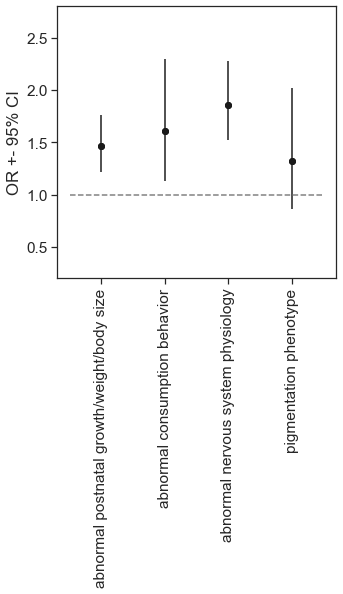

In [33]:
plt.figure(figsize=(5,5))
plt.errorbar(np.arange(len(MP_focal_list)),np.exp(log_OR_list),
             yerr=[np.subtract(np.exp(log_OR_list),np.exp(OR_CI_lower)),
                   np.subtract(np.exp(OR_CI_upper),np.exp(log_OR_list))],color='k',fmt='o')
plt.plot(np.arange(len(MP_focal_list)),np.exp(log_OR_list),'o',color='k')
plt.ylim([.2,2.8])

plt.plot([-.5,3.5],[1,1],'--',color='gray')

tmp=plt.xticks(np.arange(len(MP_focal_list)),MP2desc['description'].loc[MP_focal_list].tolist(),rotation='vertical')

plt.ylabel('OR +- 95% CI')


# ax = plt.gca()

# ax.semilogy()
# # plt.yticks(np.arange(.5, 3, .5))
# plt.yticks([0.8,1.0,1.2,1.4,1.6,2.0,2.4])
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.set_minor_formatter(ScalarFormatter())

# plt.savefig('../manuscript/figures/figure5/mouseKO_enrichment.png',dpi=300,bbox_inches='tight')
# plt.savefig('../manuscript/figures/figure5/mouseKO_enrichment.svg',dpi=300,bbox_inches='tight')


### Compare to enrichment for just seed genes (rat and human)


In [34]:
print(len(h_bmi_genes))
print(len(rat_bmi_genes))

1958
295


In [35]:
BMI_GIANT_pascal.loc[focal_genes_human].head()

NameError: name 'focal_genes_human' is not defined

In [36]:
MP_focal_list = ['MP:0002089','MP:0002069','MP:0003633','MP:0001186']
OR_p_list_hseed,OR_CI_list_hseed,log_OR_list_hseed = [],[],[]
OR_p_list_rseed,OR_CI_list_rseed,log_OR_list_rseed = [],[],[]
for MP_focal in MP_focal_list:
    MP_desc_focal = dict(MP2desc['description'])[MP_focal]
    print(MP_desc_focal)

    # focus the hierarchy on one branch, and look up all terms within that branch
    if len(MPO.parent_2_child[MP_focal])>0:
        MPO_focal = MPO.focus(MP_focal)
        focal_terms = MPO_focal.terms
    else: # if the term has no children, just look at that term
        focal_terms=MP_focal


    mgi_temp = mgi_df[mgi_df['MP'].isin(focal_terms)]
    mgi_genes = list(np.unique(mgi_temp['gene_name']))
    mgi_genes = [g.upper() for g in mgi_genes]
    print(len(mgi_genes))
    mgi_genes = list(np.intersect1d(mgi_genes,G_int.nodes()))
    print(len(mgi_genes))
    
    
    # check enrichment in human BMI seed genes
    focal_genes_human = h_bmi_genes #BMI_GIANT_pascal.sort_values('pvalue',ascending=True).head(1000).index.tolist()
    focal_genes_human = list(np.intersect1d(focal_genes_human,G_int.nodes())) # only use genes in interactome
    print(len(focal_genes_human))
    q00 = len(np.intersect1d(mgi_genes,focal_genes_human))
    q01 = len(mgi_genes)-q00

    q10 = len(focal_genes_human)-q00
    q11 = len(G_int.nodes())-q00-q01-q10

    table_temp = [[q00,q01],[q10,q11]]
    print(table_temp)

    CT= contingency_tables.Table2x2(table_temp)
    OR_p_temp = CT.log_oddsratio_pvalue()
    OR_CI_temp = CT.log_oddsratio_confint()
    log_OR_temp = CT.log_oddsratio
    print(OR_p_temp)
    print(OR_CI_temp)
    print(log_OR_temp)
    
    OR_p_list_hseed.append(OR_p_temp)
    OR_CI_list_hseed.append(OR_CI_temp)
    log_OR_list_hseed.append(log_OR_temp)
    
    # check enrichment in rat BMI seed genes
    focal_genes_rat = rat_bmi_genes
    focal_genes_rat = list(np.intersect1d(focal_genes_rat,G_int.nodes())) # only use genes in interactome
    print(len(focal_genes_rat))

    q00 = len(np.intersect1d(mgi_genes,focal_genes_rat))
    q01 = len(mgi_genes)-q00

    q10 = len(focal_genes_rat)-q00
    q11 = len(G_int.nodes())-q00-q01-q10

    table_temp = [[q00,q01],[q10,q11]]
    print(table_temp)

    CT= contingency_tables.Table2x2(table_temp)
    OR_p_temp = CT.log_oddsratio_pvalue()
    OR_CI_temp = CT.log_oddsratio_confint()
    log_OR_temp = CT.log_oddsratio
    print(OR_p_temp)
    print(OR_CI_temp)
    print(log_OR_temp)
    
    OR_p_list_rseed.append(OR_p_temp)
    OR_CI_list_rseed.append(OR_CI_temp)
    log_OR_list_rseed.append(log_OR_temp)
    
    #print(hypergeom.sf(q00,len(G_int.nodes()),len(focal_genes),len(mgi_genes)))
    
OR_CI_lower_hseed, OR_CI_upper_hseed = zip(*OR_CI_list_hseed)
OR_CI_lower_rseed, OR_CI_upper_rseed = zip(*OR_CI_list_rseed)

abnormal postnatal growth/weight/body size
Genes and Terms to keep: 39
5331
3428
1958
[[475, 2953], [1483, 13909]]
3.327229274705011e-13
(0.30050619046832056, 0.5219077530515134)
0.41120697175991694
295
[[55, 3373], [240, 15152]]
0.8472767909415606
(-0.26634535221186556, 0.3243938367212434)
0.029024242254688914
abnormal consumption behavior
Genes and Terms to keep: 51
921
644
1958
[[94, 550], [1864, 16312]]
0.0004262472612821789
(0.17861662211419257, 0.6264890199902918)
0.4025528210522422
295
[[13, 631], [282, 17894]]
0.34972601016387594
(-0.29366690566122133, 0.8295812338407254)
0.267957164089752
abnormal nervous system physiology
Genes and Terms to keep: 365
3096
2157
1958
[[328, 1829], [1630, 15033]]
1.4151493606152165e-14
(0.37499929339495175, 0.6313141662456552)
0.5031567298203035
295
[[32, 2125], [263, 16400]]
0.7387640048874247
(-0.4326299461469489, 0.30681275229841737)
-0.06290859692426576
pigmentation phenotype
Genes and Terms to keep: 125
992
521
1958
[[62, 459], [1896, 16403

Text(0.5, 0, 'OR +- 95% CI')

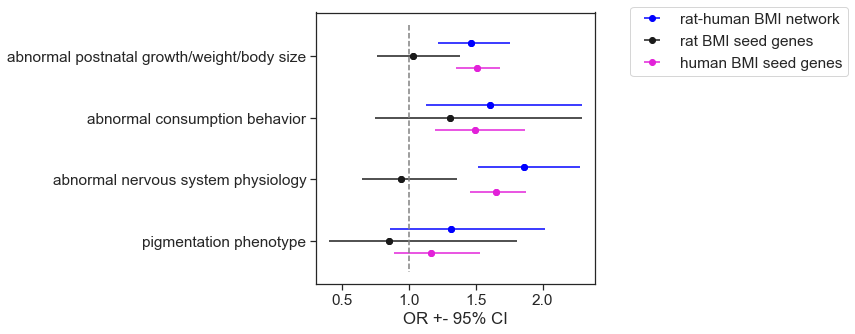

In [37]:
# plot all together
plt.figure(figsize=(5,5))

# NetColoc subgraph
plt.errorbar(np.exp(log_OR_list),np.arange(len(MP_focal_list))-.2,
             xerr=[np.subtract(np.exp(log_OR_list),np.exp(OR_CI_lower)),
                   np.subtract(np.exp(OR_CI_upper),np.exp(log_OR_list))],color='blue',fmt='o',
             label='rat-human BMI network')
plt.plot(np.exp(log_OR_list),np.arange(len(MP_focal_list))-.2,'o',color='blue')

# r seeds 
plt.errorbar(np.exp(log_OR_list_rseed),np.arange(len(MP_focal_list)),
             xerr=[np.subtract(np.exp(log_OR_list_rseed),np.exp(OR_CI_lower_rseed)),
                   np.subtract(np.exp(OR_CI_upper_rseed),np.exp(log_OR_list_rseed))],color='k',fmt='o',
             label='rat BMI seed genes')
plt.plot(np.exp(log_OR_list_rseed),np.arange(len(MP_focal_list)),'o',color='k')

# h seeds 
plt.errorbar(np.exp(log_OR_list_hseed),np.arange(len(MP_focal_list))+.2,
             xerr=[np.subtract(np.exp(log_OR_list_hseed),np.exp(OR_CI_lower_hseed)),
                   np.subtract(np.exp(OR_CI_upper_hseed),np.exp(log_OR_list_hseed))],color='#E221D9',fmt='o',
            label='human BMI seed genes')
plt.plot(np.exp(log_OR_list_hseed),np.arange(len(MP_focal_list))+.2,'o',color='#E221D9')
# plt.ylim([.2,2.8])
plt.gca().invert_yaxis()

plt.plot([1,1],[-.5,3.5],'--',color='gray')
plt.legend(bbox_to_anchor=(1.1, 1.05))

tmp=plt.yticks(np.arange(len(MP_focal_list)),MP2desc['description'].loc[MP_focal_list].tolist(),rotation='horizontal')
plt.xlabel('OR +- 95% CI')

# plt.savefig('../manuscript/figures/figure5/mouseKO_enrichment.png',dpi=300,bbox_inches='tight')
# plt.savefig('../manuscript/figures/figure5/mouseKO_enrichment.svg',dpi=300,bbox_inches='tight')

# Load BMI genes called from Brittany's pipeline

In [41]:
BMI_brittany = pd.read_csv('../data/from_brittany/gene_list_bothsources_forBrin.csv',index_col='Unnamed: 0')
print(len(BMI_brittany))
BMI_brittany.head()

5607


,MGI,file_name,zygosity,genotype_pval,genotypeLevel,genotype_lowerConf,genotype_upperConf,genotype_confLevel,genotype_SE,sex_pval,...,ctrlMale_mean,expMale_n,expMale_sd,expMale_mean,initialModel,initialModelRandEffect,finalModel,finalModelRandEffect,assay,gene_symbol
1,MGI:101760,JAX_001_BMI_MGI:101760_heterozygote.txt,het,0.892858,0.120273,1.870886,-1.630341,0.95,0.892910,0.0,...,35.901887,8.0,2.161725,38.228523,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Sfswap
2,MGI:101762,ICS_001_BMI_MGI:101762_heterozygote.txt,het,0.353620,0.536980,1.672022,-0.598062,0.95,0.578762,0.0,...,27.215938,8.0,1.594997,31.358553,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Elk3
3,MGI:101770,UCD_001_BMI_MGI:101770_homozygote.txt,homo,0.484156,-0.626632,1.130311,-2.383575,0.95,0.895321,0.0,...,36.196157,8.0,1.929343,33.939710,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Bfsp1
4,MGI:101784,JAX_001_BMI_MGI:101784_homozygote.txt,homo,0.052538,-2.209327,0.024348,-4.443001,0.95,1.136123,0.0,...,35.901887,8.0,1.321747,33.193504,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Nes
5,MGI:101785,UCD_001_BMI_MGI:101785_heterozygote.txt,het,0.703476,-0.446102,1.853124,-2.745329,0.95,1.171665,0.0,...,36.196157,7.0,2.722915,36.807684,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Mybl2


In [43]:
BMI_brit_sig = BMI_brittany[BMI_brittany['genotype_pval']<1E-4]

print(len(BMI_brit_sig))
BMI_brit_sig.head()

249


,MGI,file_name,zygosity,genotype_pval,genotypeLevel,genotype_lowerConf,genotype_upperConf,genotype_confLevel,genotype_SE,sex_pval,...,ctrlMale_mean,expMale_n,expMale_sd,expMale_mean,initialModel,initialModelRandEffect,finalModel,finalModelRandEffect,assay,gene_symbol
15,MGI:101857,MGP_001_BMI_MGI:101857_homozygote.txt,homo,8.531842e-12,-2.924726,-2.087293,-3.762158,0.95,0.427157,0.0,...,29.148561,7.0,0.865764,26.007086,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Usp15
24,MGI:101919,JAX_001_BMI_MGI:101919_heterozygote.txt,het,1.354850e-06,4.339524,6.097702,2.581345,0.95,0.896769,0.0,...,35.901887,7.0,2.106465,38.758017,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Ap1g1
27,MGI:101932,HMGU_001_BMI_MGI:101932_homozygote.txt,homo,1.291557e-08,15.347618,20.611434,10.083802,0.95,2.683478,0.0,...,30.164183,4.0,5.059710,47.213061,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Cpe
45,MGI:102709,ICS_001_BMI_MGI:102709_homozygote.txt,homo,9.222137e-05,4.197755,6.260167,2.135344,0.95,1.043488,0.0,...,27.215938,9.0,1.324204,31.769956,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Cav1
82,MGI:103040,JAX_001_BMI_MGI:103040_heterozygote.txt,het,2.113321e-11,4.639670,5.993770,3.285571,0.95,0.690666,0.0,...,35.901887,8.0,3.457596,40.543288,BMI ~ Genotype + Sex,~1 | Batch,BMI ~ Genotype + Sex,~1 | Batch,BodyComposition,Rsu1


In [45]:
# ----------- get gene mapping info from brittany -----------

In [48]:
BMI_all_genes = list(np.unique(BMI_brittany['gene_symbol']))
BMI_all_genes = [g.upper() for g in BMI_all_genes]
print(len(BMI_all_genes))
print(len(np.intersect1d(BMI_all_genes,list(G_int.nodes()))))

5001
4282


In [49]:
BMI_sig_genes = list(np.unique(BMI_brit_sig['gene_symbol']))
BMI_sig_genes = [g.upper() for g in BMI_sig_genes]
print(len(BMI_sig_genes))
print(len(np.intersect1d(BMI_sig_genes,list(G_int.nodes()))))

245
221


In [59]:
print(len(np.intersect1d(BMI_sig_genes,node_df.index.tolist())))
print(np.intersect1d(BMI_sig_genes,node_df.index.tolist()))

9
['CASQ2' 'DMD' 'NPEPPS' 'PGBD5' 'PTPRD' 'SERTAD3' 'SLC25A12' 'TNIK' 'UNK']


In [57]:
print(len(np.intersect1d(BMI_all_genes,node_df.index.tolist())))

170
